In [1]:
# importing modules
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [2]:
# fetching data from Bing Search API
key = 'e5abd66595fb4f329fde73b3a581f989'
def fetch_images(key, category, max_image:int = 150,**kargs):
    params = {'q':category,'count':max_image}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url =  "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url,headers = headers,params = params)
    response.raise_for_status()
    search_results = response.json()
    return L(search_results['value'])

In [3]:
results = fetch_images(key, 'grizzly bear', min_sz=128)
ims = results.attrgot('contentUrl')
ims

(#150) ['http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg','https://tetonvalleylodge.com/wp-content/uploads/2015/04/grizzly-bear-idaho.jpg','https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-Background-.jpg','https://www.pbs.org/wnet/nature/files/2018/07/Bear133.jpg','https://i0.wp.com/rangerrick.org/wp-content/uploads/2018/04/RRMAR13_6-11Grizzlies.jpg?fit=1156%2C650&ssl=1','https://davidsuzuki.org/wp-content/uploads/2017/04/grizzly-bears-alaska-wildlife-sanctuary-whittier.jpg','https://gohunt-assets-us-west-2.s3.amazonaws.com/wyoming-grizzly-bear-og_0.jpg','https://reidparkzoo.org/wp-content/uploads/2013/09/grzbear2812a.jpg','https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-Wallpaper-.jpg','https://i0.wp.com/www.commonsenseevaluation.com/wp-content/uploads/2013/08/Bear.jpg'...]

In [4]:
# emotion category
emotion_category = ['smiling','sad']
path = Path('person')
if not path.exists():
    path.mkdir()
    for item in emotion_category:
        destination = (path/item)
        destination.mkdir(exist_ok = True)
        results = fetch_images(key,f'{item} male face',min_size = 128)
        download_images(destination,urls =results.attrgot('contentUrl'))
        results = fetch_images(key,f'{item} female face',min_size = 128)
        download_images(destination,urls =results.attrgot('contentUrl'))
        print(f'... downloaded {item}')

In [5]:
fns = get_image_files(path)

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink);

In [20]:
emotions = DataBlock(
blocks = (ImageBlock, CategoryBlock),
get_items = get_image_files,
splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
get_y = parent_label,
item_tfms = Resize(128))

In [21]:
dls = emotions.dataloaders(path)

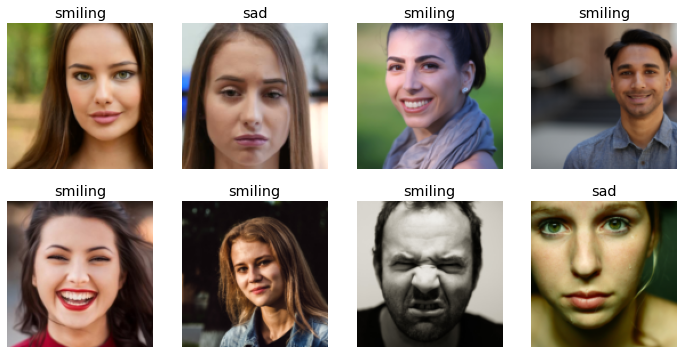

In [22]:
dls.valid.show_batch(max_n =8)

In [23]:
emotions = emotions.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = emotions.dataloaders(path)

In [24]:
learn = cnn_learner(dls,resnet18,metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.346359,0.516281,0.272727,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.848820,0.520232,0.272727,00:12
1,0.803331,0.615814,0.287879,00:11
2,0.740654,0.669398,0.212121,00:12
3,0.645726,0.597261,0.227273,00:10


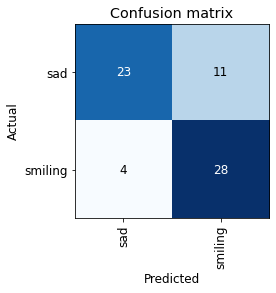

In [25]:
check = ClassificationInterpretation.from_learner(learn)
check.plot_confusion_matrix()

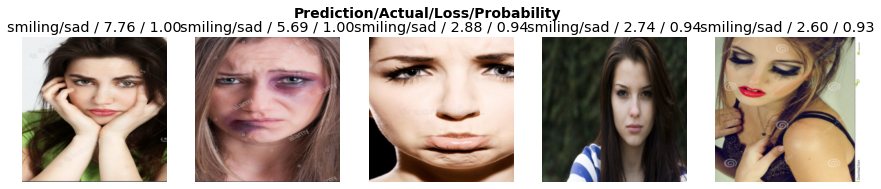

In [26]:
check.plot_top_losses(5, nrows=1)

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
# delete records which seem unfit
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [32]:
learner_inf = load_learner(path/'export.pkl')
learner_inf.predict('person/sad/00000000.jpg')

('sad', TensorImage(0), TensorImage([0.8831, 0.1169]))

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learner_inf.predict(img)

In [39]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: sad; Probability: 0.9094')

In [44]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learner_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [46]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [50]:
VBox([ widgets.Label('Upload your picture please!'), 
      btn_upload, btn_run, out_pl, lbl_pred ])

In [51]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6 MB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 57.1 MB/s eta 0:00:01
     |████████████████████████████████| 382 kB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 68 kB 12.2 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.10 O